<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/9_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Skin Lesions Classifications using Ensemble

## Initialization

In [ ]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
import random as rn
from keras import layers
from keras import models
import os
import math
import shutil
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
TRAIN_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/train'
VAL_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/val'
TEST_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset/test'
MODELS_PATH = '/content/gdrive/MyDrive/SkinCancer/Models'

CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
BATCH_SIZE = 32
RANDOM_SEED = 42
EPOCHS=50
DROPOUT = 0.3

###Dataset Loading

Note that since 450x600 is too large, It is used the interpolation tool in Keras to resize the images in 224x224, also to fit the input of most pretrained networks.

In [ ]:
val_images = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=True,
    seed=RANDOM_SEED
)

test_images = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    interpolation='bilinear',
    shuffle=False,
    seed=RANDOM_SEED
)

Found 1500 files belonging to 7 classes.
Found 1511 files belonging to 7 classes.


## Utility

In [ ]:
def evaluate_model(true_labels, predicted_labels):
  print("Accuracy on test set: " +str(metrics.accuracy_score(true_labels, predicted_labels)))
  print(metrics.classification_report(true_labels, predicted_labels, target_names=CLASSES, digits=4))
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(true_labels, predicted_labels, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

def plot_confusionmatrix(model, test_ds):
  test_labels = np.concatenate([label for image, label in test_ds], axis=0) # retrieve the labels of the test set
  test_predictions = model.predict(test_ds, verbose=1)  # probabilities for all classes
  test_predictions = np.argmax(test_predictions, axis=-1)  # index of the classes with largest probability
  # plot confusion matrix
  fig, ax = plt.subplots(figsize=(10, 10))
  ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', ax=ax, display_labels=CLASSES)

def get_accuracy(true_labels, predicted_labels):
  return metrics.accuracy_score(true_labels, predicted_labels)

## Load Models

Load the best model for each approach.

In [ ]:
vgg_model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/VGG/FT_LastBlock.h5')
inception_model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/Inception/FT_Last1.h5')
densenet_model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/DenseNet/FT_LastWhole.h5')
resnet_model = models.load_model('/content/gdrive/MyDrive/SkinCancer/Models/ResNet/FT_LastWhole.h5')

We calculate the results of each model on the test set and we concatenate the results on a single list object. The same procedure is done also for the validation set, since this results will be useful when we are gonna find the best weights for the ensemble model.

### Scores on Validation Set

In [ ]:
vgg_model_val = vgg_model.predict(val_images)
inception_model_val = inception_model.predict(val_images)
densenet_model_val = densenet_model.predict(val_images)
resnet_model_val = resnet_model.predict(val_images)

model_val_scores = [vgg_model_val, inception_model_val, densenet_model_val, resnet_model_val]

val_labels = tf.concat([label for image, label in val_images], axis = 0)

In [ ]:
TRUE_VALIDATION_LABELS = tf.concat([labels_batch for data_batch, labels_batch in val_images], axis = 0)

### Scores on Test Set

In [ ]:
vgg_model_test = vgg_model.predict(test_images)
inception_model_test = inception_model.predict(test_images)
densenet_model_test = densenet_model.predict(test_images)
resnet_model_test = resnet_model.predict(test_images)

model_test_scores = [vgg_model_test, inception_model_test, densenet_model_test, resnet_model_test]

test_labels = tf.concat([label for image, label in test_images], axis = 0)

## Average Model

This is the equivalent of using weights of 0.25.

Accuracy on test set: 0.8312375909993381
                precision    recall  f1-score   support

       Actinic     0.6364    0.5600    0.5957        50
           BCC     0.6471    0.8250    0.7253        80
Dermatofibroma     0.7000    0.3889    0.5000        18
     Keratosis     0.6722    0.7289    0.6994       166
      Melanoma     0.5917    0.5952    0.5935       168
          Nevu     0.9299    0.9086    0.9191      1007
      Vascular     0.8636    0.8636    0.8636        22

      accuracy                         0.8312      1511
     macro avg     0.7201    0.6958    0.6995      1511
  weighted avg     0.8356    0.8312    0.8320      1511



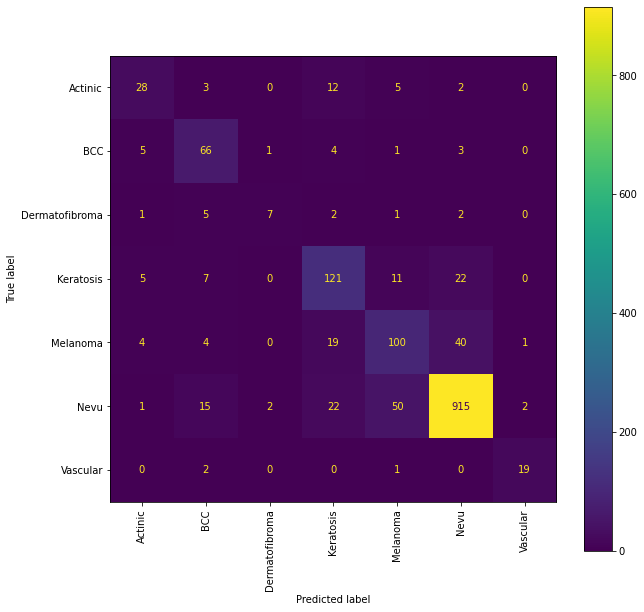

In [ ]:
model_test_scores = np.array(model_test_scores)
ensemble_scores = np.mean(model_test_scores, axis=0)
ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes

evaluate_model(test_labels, ensemble_prediction)

## Weighted Average Model

In [ ]:
def calculate_ensemble_prediction(model_scores, weights):
  model_scores = np.array(model_scores)
  ensemble_scores = np.average(model_scores, axis=0, weights=weights)
  ensemble_prediction = np.argmax(ensemble_scores, axis=-1) # argmax across classes
  return ensemble_prediction

In [ ]:
step = 0.05

#record of the best model wrt accuracy on test set
best_accuracy_model = {'weights':[], 'accuracy':0}

for a in np.arange(0,1.01,step):
  for b in np.arange(0,1.01,step):
    for c in np.arange(0,1.01,step):
      for d in np.arange(0,1.01,step):
        if (a + b + c + d == 1):
          predictions = calculate_ensemble_prediction(model_val_scores, [a, b, c, d])
          acc = get_accuracy(val_labels, predictions)
          new_model = {'weights':[a,b,c,d], 'accuracy':acc}
          if new_model['accuracy'] > best_accuracy_model['accuracy']:
            best_accuracy_model = new_model

In [ ]:
best_accuracy_model

{'weights': [0.2, 0.2, 0.30000000000000004, 0.30000000000000004],
 'accuracy': 0.6106666666666667}

Impossibile che questo venga con accuracy più bassa dell'average che usa come pesi [0.25, 0.25, 0.25, 0.25].
Invece lo è perché qui come cosa si usa validation e non il test....

Model with best accuracy: 
Weights: [0.2, 0.2, 0.30000000000000004, 0.30000000000000004]
Accuracy on test set: 0.8325612177365983
                precision    recall  f1-score   support

       Actinic     0.6364    0.5600    0.5957        50
           BCC     0.6226    0.8250    0.7097        80
Dermatofibroma     0.7273    0.4444    0.5517        18
     Keratosis     0.6705    0.7108    0.6901       166
      Melanoma     0.6000    0.6071    0.6036       168
          Nevu     0.9337    0.9096    0.9215      1007
      Vascular     0.8696    0.9091    0.8889        22

      accuracy                         0.8326      1511
     macro avg     0.7229    0.7095    0.7087      1511
  weighted avg     0.8380    0.8326    0.8339      1511



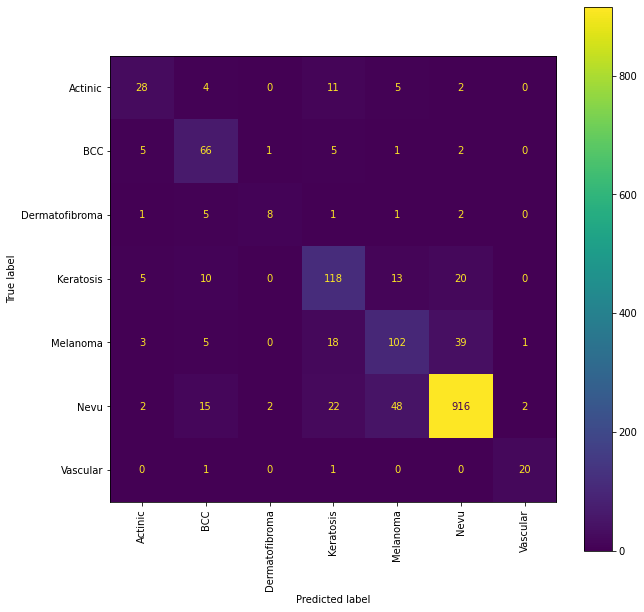

In [ ]:
print("Model with best accuracy: ")
print("Weights: " + str(best_accuracy_model['weights']))
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, best_accuracy_model['weights'])
evaluate_model(test_labels, best_acc_predictions)

## Genetic Algorithms


The weights of the ensemble can be found using Genetic algorithm. We have chromosomes composed by six genes (representing the weight of each model). Each transformation (crossover and mutation) will keep the sum of the genes of each chromosome equal to one.
The code is inspired by https://machinelearningmastery.com/simple-genetic-algorithm-from-scratch-in-python/ post.

We used as **fitness function** the **accuracy**.

In [ ]:
def get_f1(weights):
  predictions = calculate_ensemble_prediction(model_val_scores, weights)
  return metrics.accuracy_score(val_labels, predictions)

In [ ]:
# tournament selection
def tournament_selection(population, scores, k=5):
  selection_indexes = [rn.randrange(0, len(population), 1) for i in range(k)]
  selected_index = selection_indexes[0]
  for i in selection_indexes[1:]:
    # perform the tournament, i.e. check if new selection is better than last one
    if scores[i] > scores[selected_index]:
      selected_index = i
  return population[selected_index]

In [ ]:
# average crossover
def crossover(parent_1, parent_2, r_genes):
  children_1, children_2 = parent_1.copy(), parent_2.copy()
  random_genes_indexes = [rn.randrange(0, len(parent_1), 1) for i in range(r_genes)]
  for i in random_genes_indexes:
    average = (parent_1[i] + parent_2[i])/2
    children_1[i] = average
    children_2[i] = average
  return [[float(i)/sum(children_1) for i in children_1], 
          [float(i)/sum(children_2) for i in children_2]] # normalization is needed because the sum of weights must be one

In [ ]:
# all-positions mutation
def mutation(chromosome):
  index = rn.randint(0, len(chromosome)-1)
  chromosome[index] = rn.random()
  return [float(i)/sum(chromosome) for i in chromosome]

In [ ]:
def genetic_algorithm(fitness, number_of_models, population_size, number_of_generations, p_crossover, p_mutation):
  # initial population of random chromosomes
  population = []
  for i in range(population_size):
    chromosome = [rn.random() for _ in range(number_of_models)]
    chromosome = [float(i)/sum(chromosome) for i in chromosome]
    population.insert(i, chromosome)
  # keep track of best solution
  best_chromosome, best_fitness = 0, fitness(population[0])
  # enumerate generations
  for generation in range(number_of_generations):
    # evaluate all candidates in the population
    scores = [fitness(chromosome) for chromosome in population]
    # check for new best solution
    new_best = False
    for i in range(population_size):
      if scores[i] > best_fitness:
        new_best = True
        best_chromosome, best_fitness = population[i], scores[i]
    if new_best:
      print("Generation %d, best fitness = %.4f" % (generation+1, best_fitness))
    # select parents
    selected = [tournament_selection(population, scores) for _ in range(population_size)]
    # create the next generation
    children = []
    for i in range(0, population_size, 2):
      # get selected parents in pairs
      p1, p2 = selected[i], selected[i+1]
      # crossover and mutation
      if rn.random() < p_crossover:
        for c in crossover(p1, p2, r_genes=2):
          if rn.random() < p_mutation:
            # mutation
            mutation(c)
          # store for next generation
          children.append(c)
      else:
        children.append(p1)
        children.append(p2)
    # replace population
    population = children
  return [best_chromosome, best_fitness]

In [ ]:
weights = None
fmeasure = -10
for i in range(10):
  print("Iteration ", i)
  cw, cfm = genetic_algorithm(get_f1, 4, 300, 10, 0.4, 0.5)
  if cfm > fmeasure:
    fmeasure = cfm
    weights = cw
  print("------------")

Iteration  0
Generation 1, best fitness = 0.6047
Generation 2, best fitness = 0.6073
Generation 4, best fitness = 0.6093
Generation 7, best fitness = 0.6100
------------
Iteration  1
Generation 1, best fitness = 0.6073
Generation 3, best fitness = 0.6080
Generation 4, best fitness = 0.6087
Generation 6, best fitness = 0.6093
Generation 10, best fitness = 0.6100
------------
Iteration  2
Generation 1, best fitness = 0.6053
Generation 2, best fitness = 0.6073
Generation 8, best fitness = 0.6080
------------
Iteration  3
Generation 1, best fitness = 0.6080
Generation 4, best fitness = 0.6093
------------
Iteration  4
Generation 1, best fitness = 0.6080
Generation 4, best fitness = 0.6093
Generation 5, best fitness = 0.6100
------------
Iteration  5
Generation 1, best fitness = 0.6053
Generation 2, best fitness = 0.6073
Generation 3, best fitness = 0.6080
Generation 4, best fitness = 0.6087
Generation 7, best fitness = 0.6093
------------
Iteration  6
Generation 1, best fitness = 0.6053
Ge

In [ ]:
weights

[0.2547621177422938,
 0.1830630406559546,
 0.2774713818612095,
 0.28470345974054195]

Accuracy on test set: 0.8266048974189278
                precision    recall  f1-score   support

       Actinic     0.6667    0.5200    0.5843        50
           BCC     0.6932    0.7625    0.7262        80
Dermatofibroma     0.7500    0.5000    0.6000        18
     Keratosis     0.6578    0.7410    0.6969       166
      Melanoma     0.5450    0.6131    0.5770       168
          Nevu     0.9322    0.9017    0.9167      1007
      Vascular     0.8636    0.8636    0.8636        22

      accuracy                         0.8266      1511
     macro avg     0.7298    0.7003    0.7092      1511
  weighted avg     0.8344    0.8266    0.8292      1511



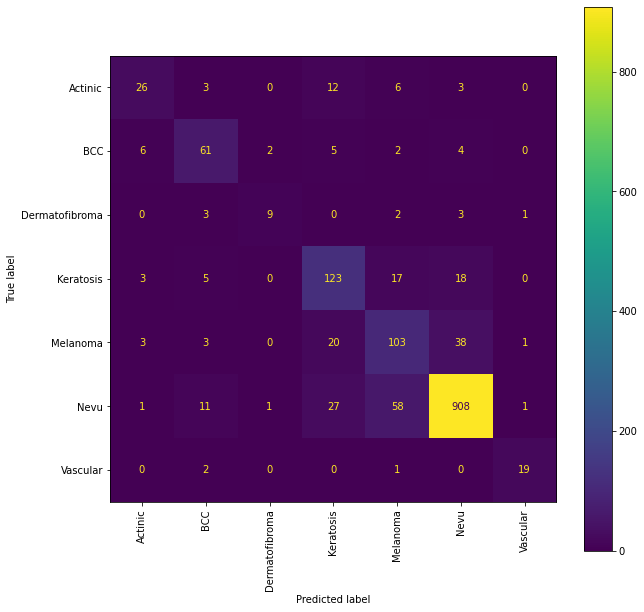

In [ ]:
best_acc_predictions = calculate_ensemble_prediction(model_test_scores, weights)
evaluate_model(test_labels, best_acc_predictions)